<a href="https://colab.research.google.com/github/amalvarezme/ProcesoDigitalSen/blob/master/ProyectoFinalPDS_20201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Control de juego por emulador de nintendo utilizando registros de EEG

## 1. Representación utilizando espectro en frecuencia, wavelets, y proyecciones basadas en varianza

## 2. Codificar representación utilizando momentos estadísticos

## 3. Detección de intención de movimiento utilizando Bayes - bosques aleatorios

## 4. Manipular emulador desde control del teclado utilizando Python.

## 5. Visualizar canales y bandas de frecuencia relevantes para la detección  (interpretabilidad - Por qué?)

Probar en base de datos pública BCI competition 42a

###  1. Representación de señales

In [26]:
# Cargar base de datos
#id del archivo: 1sui-FJI5znNJuQOk0whM6PALI89XfKss
FILEID = "1sui-FJI5znNJuQOk0whM6PALI89XfKss"
#1sui-FJI5znNJuQOk0whM6PALI89XfKss
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir
!pip install mne==0.19

--2020-11-18 13:48:31--  https://docs.google.com/uc?export=download&confirm=hoA3&id=1sui-FJI5znNJuQOk0whM6PALI89XfKss
Resolving docs.google.com (docs.google.com)... 108.177.96.102, 108.177.96.100, 108.177.96.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.96.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-b4-docs.googleusercontent.com/docs/securesc/km0hvq9f3c3hdeoj4rernl05gq078aje/iagk066k67q3b6un81e8gb4jg2pihhgm/1605707250000/09173029842254050324/02815613905460406317Z/1sui-FJI5znNJuQOk0whM6PALI89XfKss?e=download [following]
--2020-11-18 13:48:31--  https://doc-0k-b4-docs.googleusercontent.com/docs/securesc/km0hvq9f3c3hdeoj4rernl05gq078aje/iagk066k67q3b6un81e8gb4jg2pihhgm/1605707250000/09173029842254050324/02815613905460406317Z/1sui-FJI5znNJuQOk0whM6PALI89XfKss?e=download
Resolving doc-0k-b4-docs.googleusercontent.com (doc-0k-b4-docs.googleusercontent.com)... 108.177.127.132, 2a00:1450:4013:c07::84
Connectin

In [27]:
#importar paquetes
#importar carpeta con funciones
import sys
#agregar carpeta con funciones
sys.path.insert(1, './CodesBCIITL')
%matplotlib inline
from MIfunctions import * #importar todas las funciones de manejo de eeg con mne

import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, lfilter, welch, lfilter_zi, stft #, freqz
import numpy as np
from mne.io import read_raw_edf
from mne.decoding import CSP
import pandas as pd
import json as  js #conda install -c jmcmurray json
import warnings
import seaborn as sns
import mne

from numpy import matlib
import os
from matplotlib.animation import FuncAnimation
from ipywidgets import interact

import cv2 

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from joblib import dump, load
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.channels import make_standard_montage
from mne import Epochs, pick_types, events_from_annotations

#crear carpeta con resultados
from google.colab import files
import os
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

import shutil
from datetime import date, datetime

Carpeta results ya existe


In [92]:
#cargar datos
#Descripcion base de datos
#https://drive.google.com/file/d/1354HvKfp8sMckvN2t3SR9OUo9Z0yE9Uv/view?usp=sharing

sbj = 9 #sujeto facil s03, sujeto dificil s02
name = './CodesBCIITL/data/A0' + str(sbj)
filename_train = name+'T.gdf'
Ch = np.arange(0,22)# lectura canales eeg
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
clases = [769,770] # clases izquierda y derecha -> extender a pies y lengua
vt = [-1.5,3.5] #escoger ventana de analisis : -li:lf desde el estimulo cue # probar con ventana de 1 seg
#vt = [1.5,0.5] #escoger ventana de analisis : -li:lf desde el estimulo cue # probar con ventana de 1 seg
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
i_muestras, i_clases, raw, Xraw, y, ni,m = leer_bci42a_train_full(filename_train,clases,Ch,vt)
fs = raw.info['sfreq'] #frecuencia de muestreo
print(fs)


250.0


In [93]:
print(Xraw.shape) # epoch (trials) x ch x #muestras
print(y.shape)
np.unique(y)

(116, 22, 500)
(116,)


array([1., 2.])

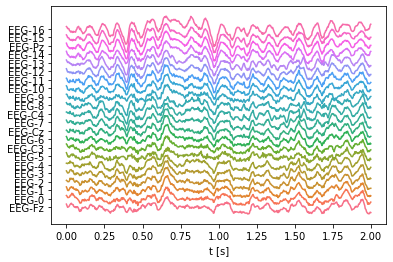

In [94]:
#eeg original trial i
i = 1
plot_eeg(data=Xraw[i],sample_rate=fs,channels_names=[raw.ch_names[i] for i in Ch])
plt.xlabel('t [s]')
plt.savefig('results/EEGOriginal.pdf', dpi=300)


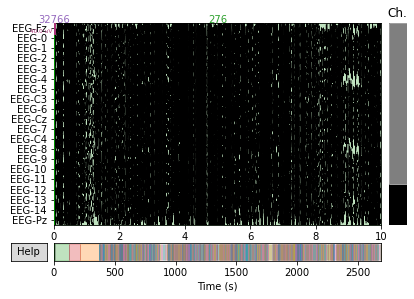

<RawGDF  |  A09T.gdf, n_channels x n_times : 25 x 673328 (2693.3 sec), ~53 kB, data not loaded>


In [95]:
f = raw.plot() # 137 intentos, 22 canales, 625= 2.5*250: #muestras
f.savefig('results/EEGcompleto.pdf', dpi=300)
#Xraw[0]
print(raw)

# 1.a Representación por FFT

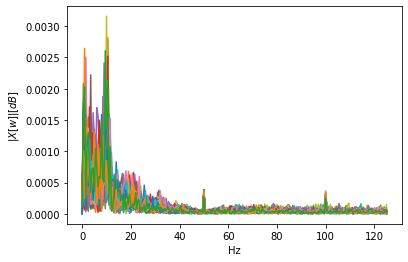

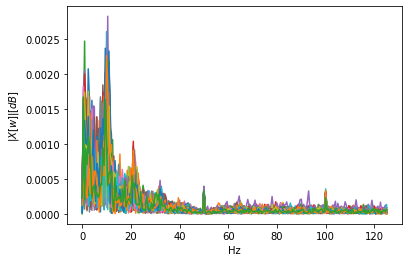

(116, 22, 251)

In [96]:
# fft por muestras eje = axis = 2
Xrfft = abs(np.fft.rfft(Xraw,axis=2)) # matriz 1 de atributos segun fft
vf = np.fft.rfftfreq(Xraw.shape[2],1/fs)  # pasar eje x a Hz segun  numero de puntos y periodo muestreo
Xrfft.shape
plt.plot(vf,Xrfft[y==1,11,:].T)
plt.xlabel('Hz')
plt.ylabel('$|X[w]| [dB]$')
plt.savefig('results/Ejfft.pdf', dpi=300)
plt.show()

plt.plot(vf,Xrfft[y==2,11,:].T)
plt.xlabel('Hz')
plt.ylabel('$|X[w]| [dB]$')
plt.show()
Xrfft.shape

NOTA: nos interesa la información en los ritmos cerebrales $\alpha\in[8,12] Hz$; $\beta\in[12,30] Hz$ para imaginación de movimiento

# 1.b Representación en STFT

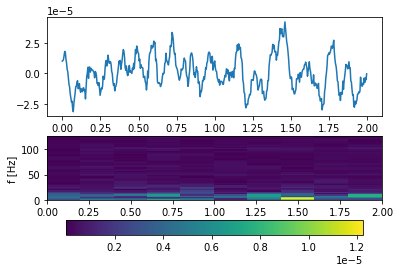

In [97]:
f,t,Xstft = stft(Xraw,fs=fs,nperseg=100,axis=2)
Xstft = abs(Xstft)
trail = 10
chi = 11

fig, ax = plt.subplots(2, 1)
vt = np.arange(0,Xraw.shape[2]/fs,1/fs)
ax[0].plot(vt,Xraw[trail,chi,:])
im = ax[1].pcolormesh(t, f, Xstft[trail,chi])
fig.colorbar(im, ax=ax[1],orientation="horizontal",pad=0.2)
plt.gca()
plt.xlabel('t [seg]')
plt.ylabel('f [Hz]')
plt.savefig('results/stft.pdf', dpi=300)


In [98]:
print(Xstft.shape) #epocas, Ch, puntos en frecuencia, #ventanas
print(f)
print(t)

(116, 22, 51, 11)
[  0.    2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5
  30.   32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5
  60.   62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5
  90.   92.5  95.   97.5 100.  102.5 105.  107.5 110.  112.5 115.  117.5
 120.  122.5 125. ]
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]


# 1.c Wavelets - cwt



In [99]:
import pywt 
#w = pywt.Wavelet('db4')
Xcwt,freq =pywt.cwt(Xraw,np.arange(1,50),'cmor',1/fs,axis=2)
Xcwt = abs(np.transpose(Xcwt,[1,2,0,3]))
Xcwt.shape

(116, 22, 49, 500)

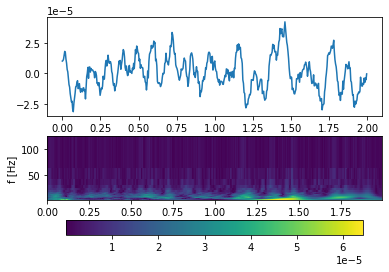

In [100]:
fig, ax = plt.subplots(2, 1)
vt = np.arange(0,Xraw.shape[2]/fs,1/fs)
ax[0].plot(vt,Xraw[trail,chi,:])
im = ax[1].pcolormesh(vt, freq, (Xcwt[trail,chi]))
fig.colorbar(im, ax=ax[1],orientation="horizontal",pad=0.2)
plt.gca()
plt.xlabel('t [seg]')
plt.ylabel('f [Hz]')

plt.savefig('results/cwt_cmor.pdf', dpi=300)



# filtrado con cwt con Pycwt

In [101]:
!pip install pycwt

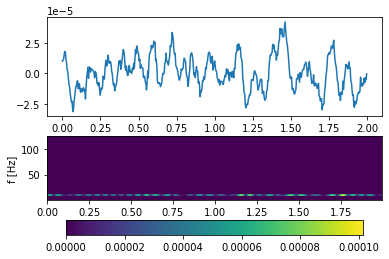

(120, 500)


In [102]:
import pycwt as wavelet
trial = 1
chi = 11
#MexicanHat
mother =  wavelet.MexicanHat() # wavelet.Morlet()
dj = 1/12 #resolucion en frecuencia
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(Xraw[trail,chi,:],dt=1/fs,wavelet=mother,dj=dj)#,freqs=np.fft.rfftfreq(Xraw.shape[2],1/fs))
ind = (freqs >= 8) & (freqs<=12)
wave[~ind,:] = 0
fig, ax = plt.subplots(2, 1)
vt = np.arange(0,Xraw.shape[2]/fs,1/fs)
ax[0].plot(vt,Xraw[trail,chi,:])
im = ax[1].pcolormesh(vt, freqs, abs(wave))
fig.colorbar(im, ax=ax[1],orientation="horizontal",pad=0.2)
plt.gca()
plt.xlabel('t [seg]')
plt.ylabel('f [Hz]')
plt.show()
print(wave.shape)


# filtrado con icwt

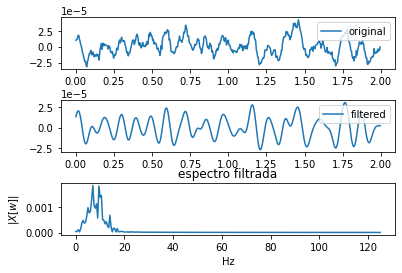

In [103]:
xe = wavelet.icwt(wave, scales, dt=1/fs,wavelet= mother,dj=dj)
#pintar espectro
vf = np.fft.rfftfreq(len(xe),1/fs)  # pasar eje x a Hz segun  numero de puntos y periodo muestreo
xefft = np.fft.rfft(xe)

plt.subplot(311)
plt.plot(vt,Xraw[trail,chi,:],label='original')
plt.legend()

plt.subplot(312)
plt.plot(vt,xe,label='filtered')
plt.legend()


plt.subplot(313)
plt.plot(vf,abs(xefft))
plt.xlabel('Hz')
plt.ylabel('$|X[w]|$')
plt.title('espectro filtrada')

plt.subplots_adjust(hspace=0.6,wspace=0.6)
plt.show()



# 1.d PSD

(116, 22, 76)


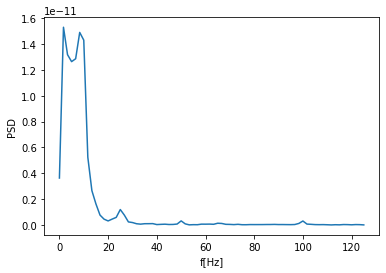

<Figure size 432x288 with 0 Axes>

In [104]:
fpsd, Xpsd = welch(Xraw, fs=fs, nperseg=150,axis=2)
print(Xpsd.shape)
fpsd
plt.plot(fpsd,Xpsd[trail,chi,:])
plt.xlabel('f[Hz]')
plt.ylabel('PSD')
plt.show()
plt.savefig('results/psd.pdf', dpi=300)

In [105]:
fpsd

array([  0.        ,   1.66666667,   3.33333333,   5.        ,
         6.66666667,   8.33333333,  10.        ,  11.66666667,
        13.33333333,  15.        ,  16.66666667,  18.33333333,
        20.        ,  21.66666667,  23.33333333,  25.        ,
        26.66666667,  28.33333333,  30.        ,  31.66666667,
        33.33333333,  35.        ,  36.66666667,  38.33333333,
        40.        ,  41.66666667,  43.33333333,  45.        ,
        46.66666667,  48.33333333,  50.        ,  51.66666667,
        53.33333333,  55.        ,  56.66666667,  58.33333333,
        60.        ,  61.66666667,  63.33333333,  65.        ,
        66.66666667,  68.33333333,  70.        ,  71.66666667,
        73.33333333,  75.        ,  76.66666667,  78.33333333,
        80.        ,  81.66666667,  83.33333333,  85.        ,
        86.66666667,  88.33333333,  90.        ,  91.66666667,
        93.33333333,  95.        ,  96.66666667,  98.33333333,
       100.        , 101.66666667, 103.33333333, 105.  

## 2. Codificar representación utilizando momentos estadísticos

# Codificar por momentos alpha y beta: stft, cwt
# fft y psd concatenar los valores del espectro en alpha y beta



In [106]:
def cal_momentos(Xf): #se calcula momentos sobre ultimo eje
  #media, mediana, var, max, min
  m =np.c_[(Xf.mean(axis=-1),np.median(Xf,axis=-1),Xf.var(axis=-1),Xf.max(axis=-1),Xf.min(axis=-1))]
  return m


In [107]:
def representacion_(Xraw,banda1=[8,12],banda2=[12,30],fs=250,
                    nperseg_stft=100,scale_cwt=np.arange(1,50),nperseg_psd=150): #Xraw: trials, Ch, Tm
    trials,Ch,Tm = Xraw.shape
    #calculo fourier
    Xrfft = abs(np.fft.rfft(Xraw,axis=2)) # matriz 1 de atributos segun fft
    vf_fft = np.fft.rfftfreq(Xraw.shape[2],1/fs)
    #calculo stft
    vf_stft,_,Xstft = stft(Xraw,fs=fs,nperseg=nperseg_stft,axis=2)
    Xstft = abs(Xstft)
    #calculo cwt
    Xcwt,vf_cwt =pywt.cwt(Xraw,scale_cwt,'cmor',1/fs,axis=2)
    Xcwt = abs(np.transpose(Xcwt,[1,2,0,3]))
    #calculo psd
    vf_psd, Xpsd = welch(Xraw, fs=fs, nperseg=nperseg_psd,axis=2)

    ###concatenar por canales e intentos los momentos de stft y cwt en alpha y beta
    ### concatenar por canalues  e intentos los valores de fft y psd en  alpha y beta
    ind_fft_b1 = (vf_fft >= banda1[0]) & (vf_fft<=banda1[1])
    ind_fft_b2 = (vf_fft >= banda2[0]) & (vf_fft<=banda2[1])
    ind_stft_b1 = (vf_stft >= banda1[0]) & (vf_stft<=banda1[1])
    ind_stft_b2 = (vf_stft >= banda2[0]) & (vf_stft<=banda2[1])
    ind_cwt_b1 = (vf_cwt >= banda1[0]) & (vf_cwt<=banda1[1])
    ind_cwt_b2 = (vf_cwt >= banda2[0]) & (vf_cwt<=banda2[1])
    ind_psd_b1 = (vf_psd >= banda1[0]) & (vf_psd<=banda1[1])
    ind_psd_b2 = (vf_psd >= banda2[0]) & (vf_psd<=banda2[1])

    Fb1 = np.c_[(Xrfft[:,:,ind_fft_b1].reshape(trials,-1),
                 cal_momentos(Xstft[:,:,ind_stft_b1,:].reshape(trials,Ch,-1)).reshape(trials,-1),
                cal_momentos(Xcwt[:,:,ind_cwt_b1,:].reshape(trials,Ch,-1)).reshape(trials,-1), 
                 Xpsd[:,:,ind_psd_b1].reshape(trials,-1))]

    Fb2 = np.c_[(cal_momentos(Xrfft[:,:,ind_fft_b2]).reshape(trials,-1),
                cal_momentos(Xstft[:,:,ind_stft_b2,:].reshape(trials,Ch,-1)).reshape(trials,-1),
                cal_momentos(Xcwt[:,:,ind_cwt_b2,:].reshape(trials,Ch,-1)).reshape(trials,-1), 
                 Xpsd[:,:,ind_psd_b2].reshape(trials,-1))]

    tam = [np.array([sum(ind_fft_b1),5,5,sum(ind_psd_b1)]),np.array([5,5,5,sum(ind_psd_b2)])]

    return Fb1,Fb2,tam # Rep [trials,P]; P = #Ch, #bandas=2, #mommentos por cwt y stft, #valores psd y fft


In [108]:
Fb1,Fb2,tam = representacion_(Xraw)
Xdata_rep = np.c_[(Fb1,Fb2)]

In [109]:
print(tam)
print(Fb1.shape)
print(Fb2.shape)
print(Xdata_rep.shape)

[array([9, 5, 5, 3]), array([ 5,  5,  5, 11])]
(116, 484)
(116, 572)
(116, 1056)


## Filtrado digital y espectral generalizado

$H(w)=Re\{H(w)\}+jIm\{H(w)\}=|H(w)|e^{j\theta_H}=r(\cos(\theta_H)+j\sin(\theta_H))$

$x_f(t)=x(t)*h(t);$ $X_f(w)=X(w)H(w)=|X(w)||H(w)|e^{j\theta_X}e^{j\theta_H}$
$$X_f(w)=X(w)H(w)=|X(w)||H(w)|e^{j(\theta_X+\theta_H)}$$

$$X(w)e^{j\theta_H}=X(w)e^{j\omega_Ht_H}$$

$$\mathcal{F}\{x(t \pm t_o)\}=X(w)e^{\mp jw t_o}$$

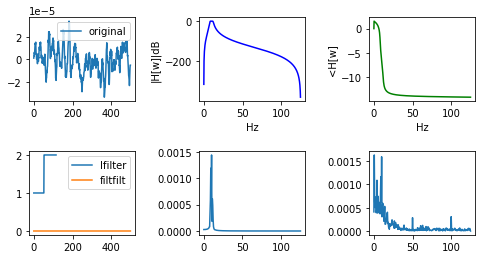

In [110]:
# Filtro pasabanda según ritmos cerebrales
#filtro butterworth
#filtfilt y lfilter
from scipy import signal
trial = 0
ch = 11
data = Xraw[trial,ch,:] #trial, ch, muestras

plt.figure(figsize=(8,4))
plt.subplot(231)
plt.plot(data,label='original')
plt.legend()

#diseñar filtro
lowcut = 8 
highcut = 12
order = 5
b, a = butter_bandpass(lowcut, highcut, fs, order=order)#diseño
w, h = signal.freqz(b,a,fs=fs)
#graficar magnitud
plt.subplot(232)
plt.plot(w, 20 * np.log10(abs(h)), 'b')
#plt.plot(w, abs(h), 'b')
plt.xlabel('Hz')
plt.ylabel('|H[w]|dB')


#graficar fase
angles = np.unwrap(np.angle(h))
plt.subplot(233)
plt.plot(w, angles, 'g')
plt.xlabel('Hz')
plt.ylabel('<H[w]')

plt.subplot(234)
yy = signal.lfilter(b, a, data)
plt.plot(y,label='lfilter')
yy = signal.filtfilt(b,a,data)
plt.plot(yy,label='filtfilt')
plt.legend()

plt.subplot(235)
Yw = np.fft.rfft(yy)
fv = np.fft.rfftfreq(yy.shape[0],1/fs)
plt.plot(fv,abs(Yw))

plt.subplot(236)
Yo = np.fft.rfft(data)
fv = np.fft.rfftfreq(data.shape[0],1/fs)
plt.plot(fv,abs(Yo))
plt.subplots_adjust(hspace=0.6,wspace=0.6)
plt.show()



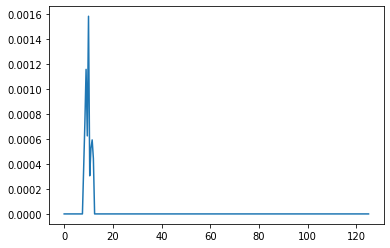

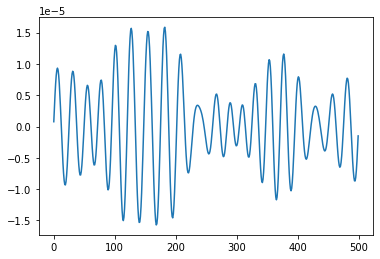

In [111]:
ind = (fv >= lowcut ) & (fv <= highcut)
Yo2 = Yo
Yo[~ind] = 0
xef = np.fft.irfft(Yo)

plt.plot(fv, abs(Yo))
plt.show()
plt.plot(xef)


In [112]:
#https://en.wikipedia.org/wiki/Neural_oscillation
#ver funcionamiento caracterizacion de common spatial patterns -> especial para motor imagery
#https://en.wikipedia.org/wiki/Common_spatial_pattern
#https://es.slideshare.net/yokotatsuya/introduction-to-common-spatial-pattern-filters-for-eeg-motor-imagery-classification
f_frec = np.array([[8,12],[12,30]])
csp = CSP_epochs_filter_extractor(fs=fs,f_frec=f_frec,ncomp = Xraw.shape[1],reg='empirical')
Xdata_csp = csp.fit_transform(Xraw,y)
print(Xraw.shape,Xdata_csp.shape)


(116, 22, 500) (116, 44)


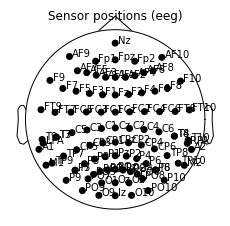

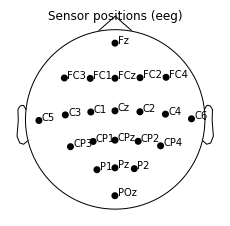

In [113]:
#se deben ajustar los nombres de los canales al montaje 10-20 de mne
montage = mne.channels.read_montage('standard_1020') #"standard_1020"
#montage = mne.channels.make_standard_montage(kind='biosemi64')
info = mne.create_info(montage.ch_names, sfreq=250, ch_types="eeg",
                           montage=montage)
f,ax = plt.subplots(1,1,figsize=(3,3))
mne.viz.plot_sensors(info, show_names=True,axes=ax)
plt.show()
#canales base de datos
channels_names = ['Fz','FC3','FC1','FCz','FC2','FC4',
                 'C5','C3','C1','Cz','C2','C4','C6',
                 'CP3','CP1','CPz','CP2','CP4',
                  'P1','Pz','P2',
                   'POz']
# Se crea un objeto mne con el montaje de los electrodos usados
montage = mne.channels.read_montage('standard_1020', channels_names)
info = mne.create_info(channels_names, sfreq=250, ch_types="eeg",
                           montage=montage)
f,ax = plt.subplots(1,1,figsize=(3,3))
mne.viz.plot_sensors(info, show_names=True,axes=ax)
f.savefig('results/MontageBCI42a.pdf', dpi=300)

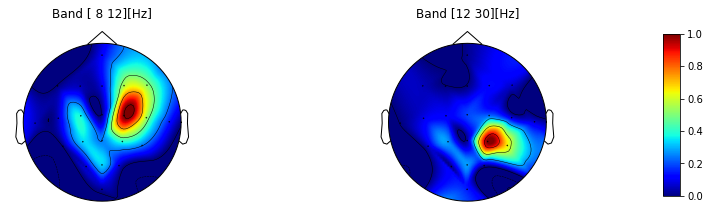

In [116]:

#visualizar en topoplot (grafica sobre sensores), canales con mas peso por representacion por bandas desde csp
f, ax = plt.subplots(1,len(csp.csp_l),figsize=(12,3))
rhov = np.zeros((csp.csp_l[0].filters_.shape[1],len(csp.csp_l)))
cmap = 'jet'
for i in range(len(csp.csp_l)):
    #rhov[:,i] = np.mean(abs(csp.csp_l[i].filters_),axis=0) #promediar pesos sobre representacion de csp
    rhov[:,i] = abs(csp.csp_l[i].filters_[0]) #promediar pesos sobre representacion de csp
    rhov[:,i] = rhov[:,i]/max(rhov[:,i])
    mne.viz.plot_topomap(rhov[:,i], info, axes=ax[i], show=False,cmap=cmap)
    ax[i].set_title('Band '+str(f_frec[i])+'[Hz]')
 
cax = f.add_axes([0.95, 0.15, 0.02, 0.75])
norm = matplotlib.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cax)
plt.savefig('results/Relevancia_CSPFilters_0.pdf', dpi=300)
plt.show()

In [117]:
csp.csp_l[0].filters_.shape

(22, 22)

In [118]:
Xdata = np.c_[(Xdata_rep,Xdata_csp)]
print(Xdata_rep.shape)
print(Xdata_csp.shape)
print(Xdata.shape)

(116, 1056)
(116, 44)
(116, 1100)


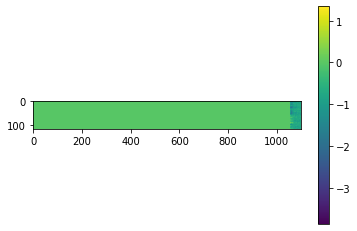

In [119]:
plt.imshow(Xdata)
plt.colorbar()

In [120]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_predict

steps = [('scaler',StandardScaler()),
         ('cla', RandomForestClassifier())]

model = Pipeline(steps)         
ye = cross_val_predict(model,Xdata,y,cv=10,verbose = 50)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s finished


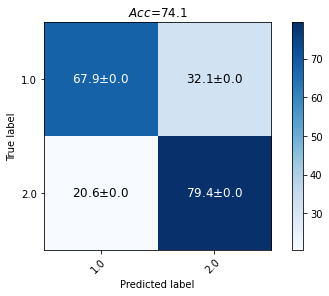

In [121]:
cm = confusion_matrix(y, ye)
cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
acc = accuracy_score(y,ye)
plot_confusion_matrix_MS(cm, np.zeros(cm.shape), np.unique(y))
plt.title('${Acc}$='+ format(100*acc,'.1f') )
plt.show()

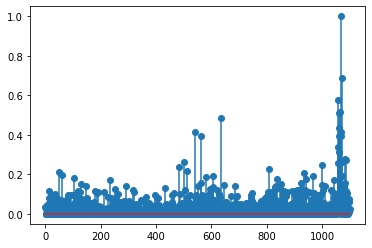

(116, 1100)


In [123]:
model.fit(Xdata,y)
rho = model['cla'].feature_importances_
rho /=rho.max()
plt.stem(rho)
plt.show()
print(Xdata.shape)

In [126]:
#construir funcion que permita mapear al espacio de canales la importancia de cada tipo de representacion en rho
# por banda
#ej: dibuje topoplot de fourier en banda  mu

# guardar con joblib
from joblib import dump, load
savedata = {
        'cm':cm,
        'rho': rho,
        'model':model,        
          } 
dump(savedata,'modeleeg.joblib')

model_load = load('modeleeg.joblib')

'''
from pynput.keyboard import Controller #Key
import time
left = 'a'
right = 'd'
tmax = 1
keyboard = Controller()
ii = 0

while ii < nepochs: #while true or input = xxxx
    print('epoch %d/%d\n'% (ii+1,nepochs))
        
    y_pro = model.predict(Xdata[ii,:,:].reshape(1,-1)) # Xraw debe incluir representacion
    
    if (y_pro == 1):
        keyboard.press(left)
        print('%s__epoch:%d' % (left,ii+1))
        time.sleep(tmax)
        keyboard.release(left)
                   
    elif (y_pro == 2):   
        keyboard.press(right)
        print('%s__epoch:%d' % (right,ii+1))
        time.sleep(tmax)
        keyboard.release(right)
        
    ii+=1  
#%%
'''


"\nfrom pynput.keyboard import Controller #Key\nimport time\nleft = 'a'\nright = 'd'\ntmax = 1\nkeyboard = Controller()\nii = 0\n\nwhile ii < nepochs: #while true or input = xxxx\n    print('epoch %d/%d\n'% (ii+1,nepochs))\n        \n    y_pro = model.predict(Xdata[ii,:,:].reshape(1,-1)) # Xraw debe incluir representacion\n    \n    if (y_pro == 1):\n        keyboard.press(left)\n        print('%s__epoch:%d' % (left,ii+1))\n        time.sleep(tmax)\n        keyboard.release(left)\n                   \n    elif (y_pro == 2):   \n        keyboard.press(right)\n        print('%s__epoch:%d' % (right,ii+1))\n        time.sleep(tmax)\n        keyboard.release(right)\n        \n    ii+=1  \n#%%\n"

In [129]:
#model_load['model'].predict(Xnew)